In [1]:
from pathlib import Path
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
AGENTS = {'la_mbda': 'LAMBDA',
          'rl2_cpo': r'RL$^2$-CPO',
          'maml_ppo_lagrangian': 'MAML-PPO-\nLagrangian',
          'rarl_cpo': 'RARL-CPO',
          'carl': 'CARL',
          'cpo': 'CPO'
         }

In [3]:
def load_evaluation(path):
    data = pd.read_json(path_or_buf=path, lines=True)
    data.set_index('step', inplace=True)
    data = data[data.columns[data.columns.str.startswith('evaluation')]].dropna()
    return data
    
def walk_summary_files(path):
    filenames = defaultdict(list)
    for p in Path(path).rglob('*.jsonl'):
        for agent in AGENTS.keys():
            if agent in str(p.parent) and agent != 'cpo':
                filenames[agent].append(p)
                break
    return filenames

def statistics(dataframes):
    df = pd.concat(dataframes)
    mean = df.groupby(df.index).mean()
    stddev = df.groupby(df.index).std()
    return mean, stddev 

In [4]:
seeds = [1, 2, 3, 4, 5, 6, 7, 8]

def walk_summary_files_task(path):
    filenames = defaultdict(list)
    for p in Path(path).rglob('*.jsonl'):
        for seed in seeds:
            if str(seed) in str(p.parent):
                filenames[seed].append(p)
                break
    return filenames
cpo_data = {seed: [load_evaluation(f) for f in filenames] for seed, filenames in walk_summary_files_task('on_policy/cpo').items()}
cpo_stats = [statistics(v)[0] for v in cpo_data.values()]

In [5]:
data = {agent: [load_evaluation(f) for f in filenames] for agent, filenames in walk_summary_files('.').items()}
stats = {k: statistics(v) for k, v in data.items()}
stats['cpo'] = statistics(cpo_stats)

In [6]:
cost_metric = ['evaluation/go_to_goal/cost_return',
  'evaluation/push_rod_mass/cost_return',
  'evaluation/collect/cost_return',
  'evaluation/push_box/cost_return',
  'evaluation/ball_to_goal/cost_return',
  'evaluation/haul_box/cost_return',
  'evaluation/follow_the_leader/cost_return',
  'evaluation/press_buttons/cost_return']

reward_metric = [val.replace('cost', 'reward') for val in cost_metric]

costs = [1.9, 15.28571429, 5.166666667, 16.42857143,
                 2.875, 1.125, 7.571428571, 18.44444444]
costs = [v - 25 for v in costs]

rewards = [13.62452295, 4.269955615, 6.5, 6.027554106, 4.320120119,
          10.16811141, 10.43562799, 15.79583601]

costs = {m: [v] for m, v in zip(cost_metric, costs)}
rewards = {m: [v] for m, v in zip(reward_metric, rewards)}
human = pd.DataFrame.from_dict({**costs, **rewards}, orient='index').transpose()
human['evaluation/average_reward_return'] = human[[col for col in human.columns if 'reward' in col]].mean(axis=1)
stats['human'] = human, human

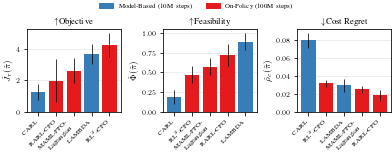

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Polygon
from tueplots import bundles, figsizes

def collect_agents(stats, metric_name, tail=2):
    vals = [agent_stats[0][metric_name].tail(tail).mean() for agent_stats in stats.values()]
    errs = [agent_stats[1][metric_name].tail(tail).mean() for agent_stats in stats.values()]
    return vals, errs
    

plt.rcParams.update(bundles.neurips2021(usetex=True))
plt.rcParams.update(figsizes.neurips2021(nrows=1, ncols=3, height_to_width_ratio=1.1))
fig, axes = plt.subplots(nrows=1, ncols=3)
metrics = ['average_reward_return', 'average_feasibilty', 'cost_rate']
summary_plot_stats = {k: v for k, v in stats.items() if k not in ['cpo', 'human']}
labels = [AGENTS[k] for k in summary_plot_stats.keys()]
titles = [r'$\uparrow$Objective', r'$\uparrow$Feasibility', r'$\downarrow$Cost Regret']
y_labels = [r'$\hat{J}_r(\tilde{\pi})$', r'$\hat{\Phi}(\tilde{\pi})$',
           r'$\hat{\rho}_c(\tilde{\pi})$']
color = [plt.get_cmap('Set1')(k in ['la_mbda', 'carl']) for k in summary_plot_stats.keys()]
for metric, ax, title, y_label in zip(metrics, axes, titles, y_labels):
    vals, errs = collect_agents(summary_plot_stats, f'evaluation/{metric}')
    sign = -1. if metric == 'cost_rate' else 1.
    vals, errs, ordered_labels, ordered_color = zip(*sorted(zip(vals, errs, labels, color), key=lambda x: x[0] * sign))
    ax.bar(ordered_labels, vals, yerr=errs, zorder=2, color=ordered_color,
          error_kw=dict(elinewidth=0.75))
    ax.set_xticklabels(ordered_labels, rotation=45, ha='right')
    ax.grid(True, linewidth=0.5, c='gainsboro', axis='y', zorder=0)
    ax.title.set_text(title)
    ax.set_ylabel(y_label)
patches = [Patch(color=v, label=k) for k, v in {'Model-Based (10M steps)': plt.get_cmap('Set1')(1),
                                               'On-Policy (100M steps)': plt.get_cmap('Set1')(0)}.items()]
leg = fig.legend(handles=patches, loc='center',
                 bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)
fig.savefig("summary.pdf")

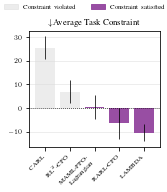

In [8]:
from tueplots import figsizes
plt.rcParams.update(bundles.neurips2021(usetex=True))
figsize = figsizes.neurips2021(height_to_width_ratio=0.9)
figsize['figure.figsize'] = figsize['figure.figsize'][0] * 0.4, figsize['figure.figsize'][1]
plt.rcParams.update(figsize)
fig, ax = plt.subplots(nrows=1, ncols=1)
summary_plot_stats = {k: v for k, v in stats.items() if k not in ['human', 'cpo']}
labels = [AGENTS[k] for k in summary_plot_stats.keys()]
vals, errs = collect_agents(summary_plot_stats, 'evaluation/average_cost_return')
vals = np.array(vals)
errs = np.array(errs)
color = [plt.get_cmap('Set1')(3) if val - err <= 0 else (0.86, 0.86, 0.86, 0.5) for val, err in zip(vals, errs)]
vals, errs, ordered_labels, ordered_color = zip(*sorted(zip(vals, errs, labels, color), key=lambda x: -x[0]))
ax.bar(ordered_labels, vals, yerr=errs, zorder=2, color=ordered_color,
      error_kw=dict(elinewidth=0.75))
ax.axhline(y=0.0, color='k', linestyle='dotted', linewidth=0.75)
ax.set_xticklabels(ordered_labels, rotation=45, ha='right')
ax.grid(True, linewidth=0.5, c='gainsboro', axis='y', zorder=0)
ax.title.set_text(r'$\downarrow$Average Task Constraint')
ax.yaxis.set_label_coords(-0.25, 0.3)
patches = [Patch(color=v, label=k) for k, v in {'Constraint violated': (0.86, 0.86, 0.86, 0.5),
                                               'Constraint satisfied': plt.get_cmap('Set1')(3)}.items()]
leg = fig.legend(handles=patches, loc='center',
                 bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)
fig.savefig("average_cost_summary.pdf")

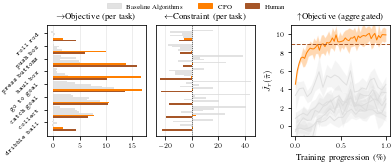

In [9]:
order = ['carl', 'rarl_cpo', 'maml_ppo_lagrangian', 'la_mbda', 'rl2_cpo', 'cpo', 'human']



def all_collect_agents(stats, metric_names):
    vals = {agent: sort_cols(stats[agent][0][cols]).tail(2).mean() for agent, cols in metric_names.items()}
    errs = {agent: sort_cols(stats[agent][1][cols]).tail(2).mean() for agent, cols in metric_names.items()}
    return vals, errs


def get_cols(stats, metric):
    cols = {agent: [col for col in data[0].columns if (metric in col and 'average' not in col)] 
                for agent, data in stats.items()
            }
    return cols

def sort_cols(df):
    df = df.reindex(sorted(df.columns), axis=1)
    return df

plt.rcParams.update(bundles.neurips2021(usetex=True))
plt.rcParams.update(figsizes.neurips2021(nrows=1.3, ncols=3, height_to_width_ratio=0.9))
fig, axes = plt.subplots(nrows=1, ncols=3)
metrics = ['reward_return', 'cost_return']
labels = [r'\texttt{dribble ball}', r'\texttt{collect}', r'\texttt{catch goal}', r'\texttt{go to goal}',
          r'\texttt{haul box}', r'\texttt{press buttons}', r'\texttt{push box}', r'\texttt{roll rod}']
titles = [r'$\rightarrow$Objective (per task)', r'$\leftarrow$Constraint (per task)', r'$\uparrow$Objective']
x = np.arange(len(labels))
algos_to_take = [k for k in order]
width = 0.9 / len(algos_to_take)
for ax, metric, title in zip(axes[:2], metrics, titles):
    cols = get_cols(stats, metric)
    vals, errs = all_collect_agents(stats, cols)
    sign = -1. if metric == 'cost_return' else 1.
    for i, agent in enumerate(reversed(algos_to_take)):
        color = dict(cpo=plt.get_cmap('Set1')(4), human=plt.get_cmap('Set1')(6))
        color = color.get(agent, (0.86, 0.86, 0.86, 0.8))
        shift = x - (len(algos_to_take) - i + 1) * width
        ax.barh(shift, vals[agent], width, zorder=2,
              error_kw=dict(elinewidth=0.2), label=agent, align='center',
               color=color)
    ax.grid(True, linewidth=0.5, c='gainsboro', axis='x', zorder=0)
    ax.title.set_text(title)
axes[0].set_yticks(x - width * 3.5, labels, rotation=45, ha='right', fontname='monospace')
axes[1].get_yaxis().set_visible(False)
axes[1].axvline(x=0.0, color='k', linestyle='dotted', linewidth=0.75)

times = dict(cpo=30000)
for i, agent in enumerate(['carl','la_mbda', 'rarl_cpo', 'rl2_cpo', 'maml_ppo_lagrangian', 'cpo']):
    color = dict(cpo=plt.get_cmap('Set1')(4), human=plt.get_cmap('Set1')(6))
    color = color.get(agent, (0.86, 0.86, 0.86, 0.8))
    stats[agent][0].index * times.get(agent, 200000),
    t = stats[agent][0].index
    x = np.linspace(0., 1., len(t))
    vals = stats[agent][0]['evaluation/average_reward_return']
    errs = stats[agent][1]['evaluation/average_reward_return']
    axes[2].plot(x, vals, color=color, linewidth=1)
    axes[2].fill_between(x, vals - errs, vals + errs, alpha=0.3, color=color, edgecolor='w')
axes[2].axhline(y=stats['human'][0].iloc[-1]['evaluation/average_reward_return'], linewidth=1, 
                color=plt.get_cmap('Set1')(6), linestyle='--')
axes[2].set_ylim(-1, 11)
ax.grid(True, linewidth=0.5, c='gainsboro', axis='x', zorder=0)
axes[2].title.set_text(r'$\uparrow$Objective (aggregated)')
axes[2].set_ylabel(y_labels[0])
axes[2].set_xlabel('Training progression (\%)')


patches = [Patch(color=v, label=k) for k, v in {'Baseline Algorithms': (0.86, 0.86, 0.86, 0.8),
                                               'CPO': plt.get_cmap('Set1')(4),
                                               'Human': plt.get_cmap('Set1')(6)}.items()]
leg = fig.legend(handles=patches, loc='center',
                 bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False)
fig.savefig("independent.pdf")

In [10]:
import matplotlib.gridspec as gridspec

name_map = dict(dribble_ball='ball_to_goal', collect='collect', catch_goal='follow_the_leader', go_to_goal='go_to_goal',
               haul_box='haul_box', press_buttons='press_buttons', push_box='push_box', roll_rod='push_rod_mass')
algo_map = dict(la_mbda='LAMBDA', rl2_cpo=r'RL$^2$-CPO', rarl_cpo='RARL-CPO', maml_ppo_lagrangian='MAML-PPO-Lagrangian',
               carl='CARL')

def draw_task(axes, task_name, algos, row, color_i):
    metrics = ['reward_return', 'cost_return']
    titles = [r'$\uparrow$Objective (per task)', r'$\downarrow$Constraint (per task)']
    for j, metric, title in zip(range(2), metrics, titles):
        for i, agent in enumerate(algos):
            color=plt.get_cmap('tab10')((i + color_i) % 10)
            x = stats[agent][0].index * 200000
            task_id = name_map[strip_curly(task_name)]
            vals = stats[agent][0][f'evaluation/{task_id}/{metric}']
            errs = stats[agent][1][f'evaluation/{task_id}/{metric}']
            ax = axes[j]
            ax.plot(x, vals, linewidth=1, color=color, label=algo_map[agent])
            ax.fill_between(x, vals - errs, vals + errs, alpha=0.3, color=color, edgecolor=(1., 1., 1., 0))
            if ax.is_first_row():
                ax.set_title(title)
            if not ax.is_first_col():
                ax.axhline(y=0.0, color='k', linestyle='dotted', linewidth=0.75)
    axes[0].annotate(task_name, (-0.4, 0.5), ha='center', va='center',
                               xycoords='axes fraction', size=7,
                               textcoords='offset points', rotation=45)
            
def strip_curly(s):
    return s[s.find("{")+1:s.find("}")].replace(' ', '_')

def draw_algo_summary(algos, name, color_i=0):
    plt.rcParams.update(bundles.neurips2021(usetex=True))
    figsize = figsizes.neurips2021(nrows=4.5, ncols=3, height_to_width_ratio=0.9)
    figsize['figure.figsize'] = figsize['figure.figsize'][0] * 3 / 8, figsize['figure.figsize'][1]
    plt.rcParams.update(figsize)
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
    titles = [r'$\uparrow$Objective', r'$\uparrow$Feasibility', r'$\downarrow$Cost Regret']
    metrics = ['average_reward_return', 'average_feasibilty', 'cost_rate']
    y_labels = [r'$\hat{J}_r(\tilde{\pi})$', r'$\hat{\Phi}(\tilde{\pi})$',
           r'$\hat{\rho}_c(\tilde{\pi})$']
    for ax, metric, title, y_label in zip(axes, metrics, titles, y_labels):
        for i, agent in enumerate(algos):
            color=plt.get_cmap('tab10')((i + color_i) % 10)
            x = stats[agent][0].index * 200000
            vals = stats[agent][0][f'evaluation/{metric}']
            errs = stats[agent][1][f'evaluation/{metric}']
            ax.plot(x, vals, linewidth=1, color=color)
            ax.fill_between(x, vals - errs, vals + errs, alpha=0.3, color=color, edgecolor=(1., 1., 1., 0))
            ax.title.set_text(title)
            ax.set_ylabel(y_label)
    fig.savefig(f"{name}_summary.pdf")
    plt.rcParams.update(bundles.neurips2021(usetex=True))
    figsize = figsizes.neurips2021(nrows=4.5, ncols=3, height_to_width_ratio=0.9)
    figsize['figure.figsize'] = figsize['figure.figsize'][0] * 5 / 8, figsize['figure.figsize'][1]
    plt.rcParams.update(figsize)
    fig, axes = plt.subplots(nrows=8, ncols=2, sharex=True)
    labels = [r'\texttt{dribble ball}', r'\texttt{collect}', r'\texttt{catch goal}', r'\texttt{go to goal}',
      r'\texttt{haul box}', r'\texttt{press buttons}', r'\texttt{push box}', r'\texttt{roll rod}']
    for i, task_name in enumerate(labels):
        draw_task(axes[i, :], task_name, algos, i, color_i)
    leg = fig.legend(*axes[0, 0].get_legend_handles_labels(), loc='center', 
                     bbox_to_anchor=(0.2, 1.01), ncol=3, frameon=False,
                    handlelength=1.2)
    fig.savefig(f"{name}_tasks.pdf")
    


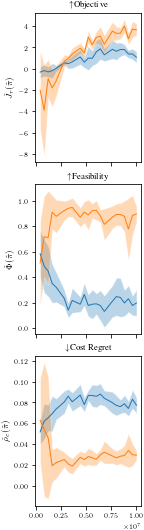

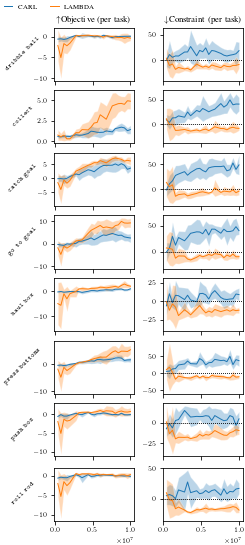

In [11]:
draw_algo_summary(['carl', 'la_mbda'], 'model_based')